# Objectives
Try to determine which news sources have the most reliable data to inform decisions in the stock market. We will be analyzing tweets from big companies such as Bloomberg, JP Morgan, and Goldman Sachs to see whether their tweets or the general sentiment of responses are correlated with increases or decreases in stock prices. We will use this as a benchmark to compare less popular sources of stock market data such as Reddit.

# Data Sources
- Twitter Kaggle Datasets
- Yahoo Finance API
- Twitter API
- Reddit API

# Hypothesis
We think that the sentiment of tweets from big stock market information sources will be reliable and have a positive correlation to stock prices. Less popular sources for stock information like Reddit will be more error prone, but will provide opportunities that yield high profit. The reasoning behind this is that people trust news from companies such as Bloomberg making those bets safer, but also less profitable. Random insights from Redditors may be wrong most of the time, but may "hit the jackpot."

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import yfinance as yf
import tweepy
import config

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
nltk.download('punkt')
nltk.download('stopwords')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from datetime import datetime, timedelta

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asher\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asher\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Exploration of [Twitter Kaggle Dataset](https://www.kaggle.com/davidwallach/financial-tweets)
This dataset contains financial tweets regarding stocks traded on NYSE, NASDAQ, and the S&P 500.

In [2]:
skiprows = [730, 2835, 3057, 3112, 3193, 3204, 3254, 3519, 4077, 4086, 4087, 4498]
tweet_df = pd.read_csv('./datasets/stockerbot-export.csv', skiprows=skiprows, parse_dates=['timestamp'])

# Drop last five rows since they seem to be in a different language
tweet_df = tweet_df[:-5]
tweet_df.head()

,id,text,timestamp,source,symbols,company_names,url,verified
0,1019696670777503700,VIDEO: “I was in my office. I was minding my o...,2018-07-18 21:33:26+00:00,GoldmanSachs,GS,The Goldman Sachs,https://twitter.com/i/web/status/1019696670777...,True
1,1019709091038548000,The price of lumber $LB_F is down 22% since hi...,2018-07-18 22:22:47+00:00,StockTwits,M,Macy's,https://twitter.com/i/web/status/1019709091038...,True
2,1019711413798035500,Who says the American Dream is dead? https://t...,2018-07-18 22:32:01+00:00,TheStreet,AIG,American,https://buff.ly/2L3kmc4,True
3,1019716662587740200,Barry Silbert is extremely optimistic on bitco...,2018-07-18 22:52:52+00:00,MarketWatch,BTC,Bitcoin,https://twitter.com/i/web/status/1019716662587...,True
4,1019718460287389700,How satellites avoid attacks and space junk wh...,2018-07-18 23:00:01+00:00,Forbes,ORCL,Oracle,http://on.forbes.com/6013DqDDU,True


Text(0.5, 0, 'Number of Times Tweeted')

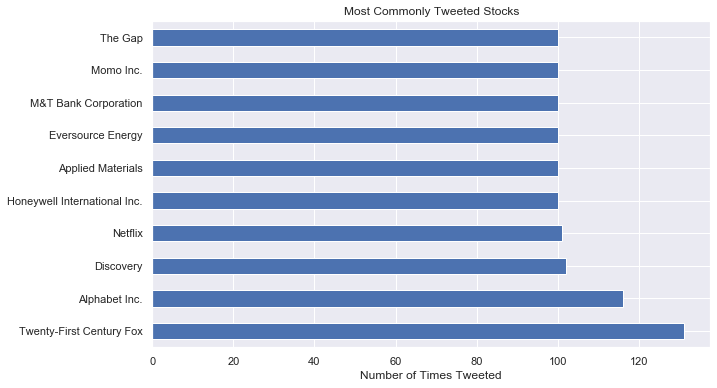

In [3]:
ax = tweet_df.company_names.value_counts().sort_values(ascending=False).head(10).plot.barh(figsize=(10, 6))
ax.set_title('Most Commonly Tweeted Stocks')
ax.set_xlabel('Number of Times Tweeted')

It is nice to see that this dataset has many tweets (around 100) for the most frequent companies. This will help us in determing the general sentiment around these companies over time to compare to stock prices. Many big names such as 21st Century Fox, Alphabet (parent company of Google), and Netflix also appear which are very established companies.

Text(0.5, 0, 'Twitter Users')

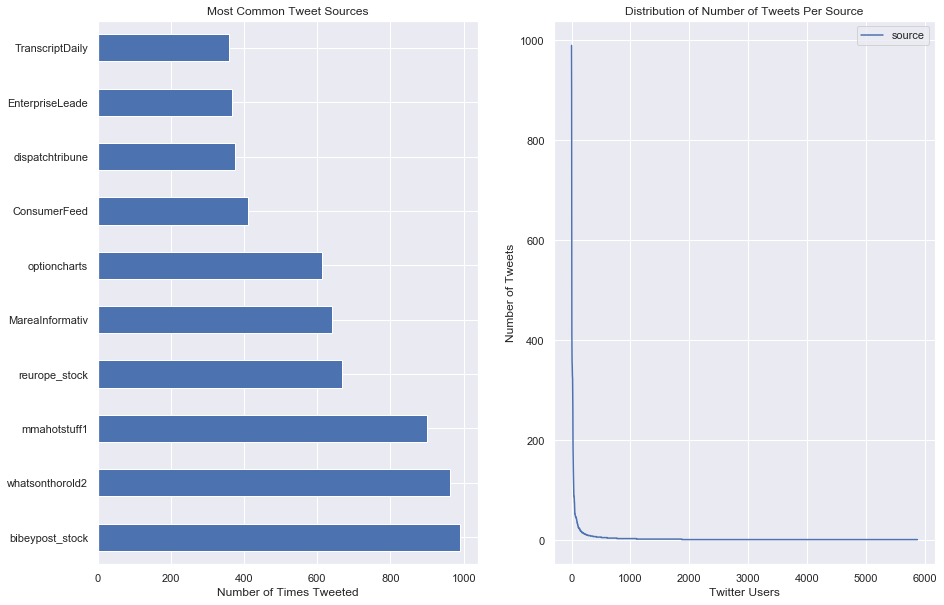

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2)

tweet_df.source.value_counts().head(10).plot.barh(ax=ax1, figsize=(15, 10))
ax1.set_title('Most Common Tweet Sources')
ax1.set_xlabel('Number of Times Tweeted')

tweet_df.source.value_counts().reset_index().plot(ax=ax2)
ax2.set_title('Distribution of Number of Tweets Per Source')
ax2.set_ylabel('Number of Tweets')
ax2.set_xlabel('Twitter Users')

This is also a nice feature of our data. The bar chart on the left worried me that our dataset was only going to have a few users that tweet a lot. This would create a lot of bias in any correlations we find. But if you look at the distribution graph on the right, it shows that there are only a few users who really tweet a lot; most users in this dataset only tweet a few times which gives us a better sample. Later we will try using the Twitter API to sample a lot of tweets from specific demographics of users.

Text(0, 0.5, 'Count')

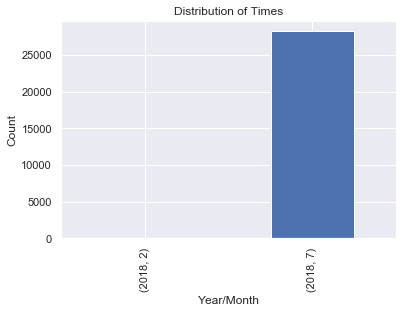

In [5]:
ax = tweet_df.groupby([tweet_df.timestamp.dt.year, tweet_df.timestamp.dt.month])['id'].count().plot(kind='bar')
ax.set_title('Distribution of Times')
ax.set_xlabel('Year/Month')
ax.set_ylabel('Count')

The one unfortunate thing about this dataset is it primarily includes tweets from July 2018 and a few tweets it seems from February 2018. We will likely need to pull in more data using the Twitter API, but this dataset will provide a good starting place.

# Collecting Stock Data Through the Yahoo Finance API
We were originally going to compare this Twitter dataset against some Kaggle stocks datasets. Given that our Twitter dataset only covers one month and the Kaggle datasets are very large, we are instead going to use the yfinance Python module to collect data for this specific month.

In [6]:
# Lets identify the top 30 stocks (based on frequency) from our Twitter dataset and use that with yfinance
common_tickers = tweet_df.symbols.value_counts().sort_values(ascending=False).head(30)
common_tickers.head()

NFLX    101
AMAT    100
ES      100
GPS     100
HON     100
Name: symbols, dtype: int64

In [7]:
# Queries Yahoo Finance API for these stocks on the month of July 2018
stocks_df = yf.download(tickers=list(common_tickers.index), start='2018-07-01', end='2018-07-31')
stocks_df.head()

[*********************100%***********************]  30 of 30 completed

3 Failed downloads:
- OMG: No data found for this date range, symbol may be delisted
- ARNC: Data doesn't exist for startDate = 1530417600, endDate = 1533009600
- FOX: Data doesn't exist for startDate = 1530417600, endDate = 1533009600


Adj Close                                                    \
                 ABBV       AMAT ARNC         BLK          D        DFS   
Date                                                                      
2018-07-02  80.599098  43.812244  NaN  465.989349  61.225769  66.760170   
2018-07-03  81.031921  42.968220  NaN  458.311768  61.995003  66.187805   
2018-07-05  81.785034  43.582054  NaN  458.955444  62.379616  66.225349   
2018-07-06  83.897171  44.243843  NaN  458.684906  62.630074  66.093971   
2018-07-09  84.001045  44.617893  NaN  470.261902  60.894825  67.576477   

                                                  ...   Volume           \
                   ES         ESS FOX        GPS  ...     MOMO      MTB   
Date                                              ...                     
2018-07-02  55.400024  220.294998 NaN  28.312382  ...  4815300   732600   
2018-07-03  55.869362  220.294998 NaN  28.767450  ...  2118100   383100   
2018-07-05  56.057095  222.607773 NaN  28.196383  ...  3498100   680100   
2018-07-06  56.610909  223.838806 NaN  27.893003  ...  4059300   829500   
2018-07-09  54.874374  222.589127 NaN  27.500397  ...  5586900  1108800   

                                                                                
                NFLX     NTNX OMG       ON       PBR    SQQQ      TEL      UPS  
Date                                                                            
2018-07-02   8142500  2096200 NaN  4726700  14640200  749600  1671100  2252300  
2018-07-03   5280300  1296300 NaN  2400500  15707700  509200   815400  1145700  
2018-07-05   8448900  2332100 NaN  7132400  21271900  841100  1521900  2866800  
2018-07-06   8629600  2291100 NaN  4202200  13076300  837000   986000  2022400  
2018-07-09  11127500  2527400 NaN  3749400  18007000  617600  1140300  2103600  

[5 rows x 180 columns]

# Cleaning Yahoo Finance Data

In [8]:
# Only want Open, Close, and Volume. Drop the rest
stocks_df.drop(['Adj Close', 'Low', 'High'], axis=1, inplace=True)

# Columns are multi-indexed, so flatten this
stocks_df.columns = ['_'.join(multi_col) for multi_col in stocks_df.columns]

# Drop FOX, OMG, and ARNC cols since we weren't able to get data for them
stocks_df.drop(list(stocks_df.filter(regex='(FOX)|(OMG)|(ARNC)$')), axis=1, inplace=True)

stocks_df.head()

,Close_ABBV,Close_AMAT,Close_BLK,Close_D,Close_DFS,Close_ES,Close_ESS,Close_GPS,Close_GRPN,Close_HLT,...,Volume_MHK,Volume_MOMO,Volume_MTB,Volume_NFLX,Volume_NTNX,Volume_ON,Volume_PBR,Volume_SQQQ,Volume_TEL,Volume_UPS
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-02,93.110001,45.680000,499.519989,68.449997,71.150002,59.020000,236.220001,31.730000,86.199997,79.300003,...,839600,4815300,732600,8142500,2096200,4726700,14640200,749600,1671100,2252300
2018-07-03,93.610001,44.799999,491.290009,69.309998,70.540001,59.520000,236.220001,32.240002,85.199997,79.449997,...,405700,2118100,383100,5280300,1296300,2400500,15707700,509200,815400,1145700
2018-07-05,94.480003,45.439999,491.980011,69.739998,70.580002,59.720001,238.699997,31.600000,87.599998,79.690002,...,414600,3498100,680100,8448900,2332100,7132400,21271900,841100,1521900,2866800
2018-07-06,96.919998,46.130001,491.690002,70.019997,70.440002,60.310001,240.020004,31.260000,87.199997,80.559998,...,479100,4059300,829500,8629600,2291100,4202200,13076300,837000,986000,2022400
2018-07-09,97.040001,46.520000,504.100006,68.080002,72.019997,58.459999,238.679993,30.820000,96.599998,80.940002,...,426000,5586900,1108800,11127500,2527400,3749400,18007000,617600,1140300,2103600


This is a lot easier to work with. The data is not exactly tidy since the tickers are included in column names, but this has every price lined up by the date which should make it easier to graph. When graphing, we will just use regex to select the columns corresponding to a specific ticker. Such a dataset would be tidy. Later during the Twitter API parsing, we transform this dataset into tidy data.

# NLP and Sentiment Analysis on Tweets
Now that we have some tweets and stock price information for the corresponding time period, we can begin to do some analysis. We will start by doing some NLP on the Tweets and then we can compare them to changes in stock price over time.

We will be using VADER (Valence Aware Dictionary and Sentiment Reasoner) to figure out the sentiment. This gives us a reliable way of determining sentiment without labeling our own data and generating models. This rule-based analysis tool was explicitly designed for social media data which is perfect for this scenario.

In [9]:
# First filter for Tweets talking about our common tickers
relevant_tickers = tweet_df[tweet_df.symbols.isin(common_tickers.index)].reset_index()

print(relevant_tickers.shape)
relevant_tickers.head()

(2906, 9)


,index,id,text,timestamp,source,symbols,company_names,url,verified
0,8,1019720723441635300,Senate wants emergency alerts to go out throug...,2018-07-18 23:09:00+00:00,TechCrunch,NFLX,Netflix,https://tcrn.ch/2L8DsgT,True
1,21,1019737727477174300,Templeton and BlackRock say now's the time to ...,2018-07-19 00:16:34+00:00,business,BLK,BlackRock,https://bloom.bg/2NmXZLe,True
2,46,1016109247048945700,In 2 days I doubled my account with the option...,2018-07-08 23:58:17+00:00,HarryPickens2,HSY,The Hershey Company,http://Optionsbypros.com,False
3,82,1016153595522281500,Weekly Recap: $HSY price moved 4.28% since pos...,2018-07-09 02:54:31+00:00,aboutheoptions,HSY,The Hershey Company,https://twitter.com/i/web/status/1016153595522...,False
4,108,1016208393378283500,$AR $CGC $DAVE $GNC $HSY $ICON $KMB $M $PEP $P...,2018-07-09 06:32:15+00:00,SeekingAlpha,HSY,The Hershey Company,https://seekingalpha.com/article/4185993-shari...,False


## Cleaning Up Tweets with NLTK

In [10]:
tt = TweetTokenizer()

def clean_tweet(s):
    # Removing punctuation and stop words (e.g 'the', 'is', 'which')
    return ' '.join(wd for wd in tt.tokenize(s.lower()) if wd.isalnum() and wd not in set(stopwords.words('english')))

# Sample usage
print(relevant_tickers.text[1])
print(clean_tweet(relevant_tickers.text[1]))

Templeton and BlackRock say now's the time to buy emerging markets https://t.co/h4z90nxqwH https://t.co/6FkVrZlu3j
templeton blackrock say time buy emerging markets


In [11]:
# Now apply this cleanup to every tweet
relevant_tickers.text = relevant_tickers.text.apply(clean_tweet)
relevant_tickers.head()

,index,id,text,timestamp,source,symbols,company_names,url,verified
0,8,1019720723441635300,senate wants emergency alerts go netflix spoti...,2018-07-18 23:09:00+00:00,TechCrunch,NFLX,Netflix,https://tcrn.ch/2L8DsgT,True
1,21,1019737727477174300,templeton blackrock say time buy emerging markets,2018-07-19 00:16:34+00:00,business,BLK,BlackRock,https://bloom.bg/2NmXZLe,True
2,46,1016109247048945700,2 days doubled account option trades xrx mrtx,2018-07-08 23:58:17+00:00,HarryPickens2,HSY,The Hershey Company,http://Optionsbypros.com,False
3,82,1016153595522281500,weekly recap hsy price moved since post next s...,2018-07-09 02:54:31+00:00,aboutheoptions,HSY,The Hershey Company,https://twitter.com/i/web/status/1016153595522...,False
4,108,1016208393378283500,ar cgc dave gnc hsy icon kmb pep pg rrc smrt wtw,2018-07-09 06:32:15+00:00,SeekingAlpha,HSY,The Hershey Company,https://seekingalpha.com/article/4185993-shari...,False


## Perform Sentiment Analysis with Vader

In [12]:
sent = SentimentIntensityAnalyzer()
relevant_tickers['sentiment'] = relevant_tickers.text.apply(lambda s: sent.polarity_scores(s)['compound'])

# a compound sentiment value is positive if >= 0.05, negative if <= -0.05, neutral if in between
relevant_tickers.head()

,index,id,text,timestamp,source,symbols,company_names,url,verified,sentiment
0,8,1019720723441635300,senate wants emergency alerts go netflix spoti...,2018-07-18 23:09:00+00:00,TechCrunch,NFLX,Netflix,https://tcrn.ch/2L8DsgT,True,-0.3818
1,21,1019737727477174300,templeton blackrock say time buy emerging markets,2018-07-19 00:16:34+00:00,business,BLK,BlackRock,https://bloom.bg/2NmXZLe,True,0.0000
2,46,1016109247048945700,2 days doubled account option trades xrx mrtx,2018-07-08 23:58:17+00:00,HarryPickens2,HSY,The Hershey Company,http://Optionsbypros.com,False,0.0000
3,82,1016153595522281500,weekly recap hsy price moved since post next s...,2018-07-09 02:54:31+00:00,aboutheoptions,HSY,The Hershey Company,https://twitter.com/i/web/status/1016153595522...,False,-0.2960
4,108,1016208393378283500,ar cgc dave gnc hsy icon kmb pep pg rrc smrt wtw,2018-07-09 06:32:15+00:00,SeekingAlpha,HSY,The Hershey Company,https://seekingalpha.com/article/4185993-shari...,False,0.0000


So now each tweet has a value ranging from -1 to 1 representing how positive/negative the sentiment of the tweet is. My current worry is that many of these tweets are factual in nature meaning the sentiment score will not be indicative of stock performance. Later we will try to look at other things such as random Tweets from the last week and compare sentiment of those tweets to stock performance. For now let's take a look at the sentiment distribution.

Text(0, 0.5, 'Sentiment')

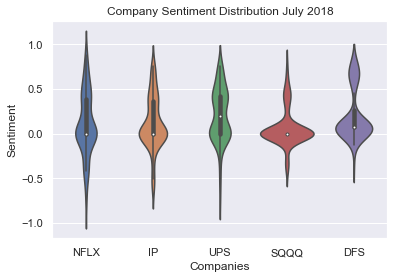

In [27]:
# Violin plot to show sentiment distribution
ticker_subset = relevant_tickers[relevant_tickers.symbols.isin(['NFLX', 'IP', 'SQQQ', 'DFS', 'UPS'])]
ax = sns.violinplot(x='symbols', y='sentiment', data=ticker_subset)
ax.set_title('Company Sentiment Distribution July 2018')
ax.set_xlabel('Companies')
ax.set_ylabel('Sentiment')

Looking at the sentiment distributions, we see that these companies generally have a neutral sentiment score which will not be very interesting for finding correlations to stock prices. SQQQ in particular has a lot of neutral tweets which makes sense since it is an index fund and it is harder to have an opinion on a collection of stocks. Even with all the neutral tweets, this data still shows unique insights as to how people feel about these companies since each company has a slightly different distribution.

## Sentiment vs Stock Price Performance
Now lets see how these sentiments over time correlate against stock performance

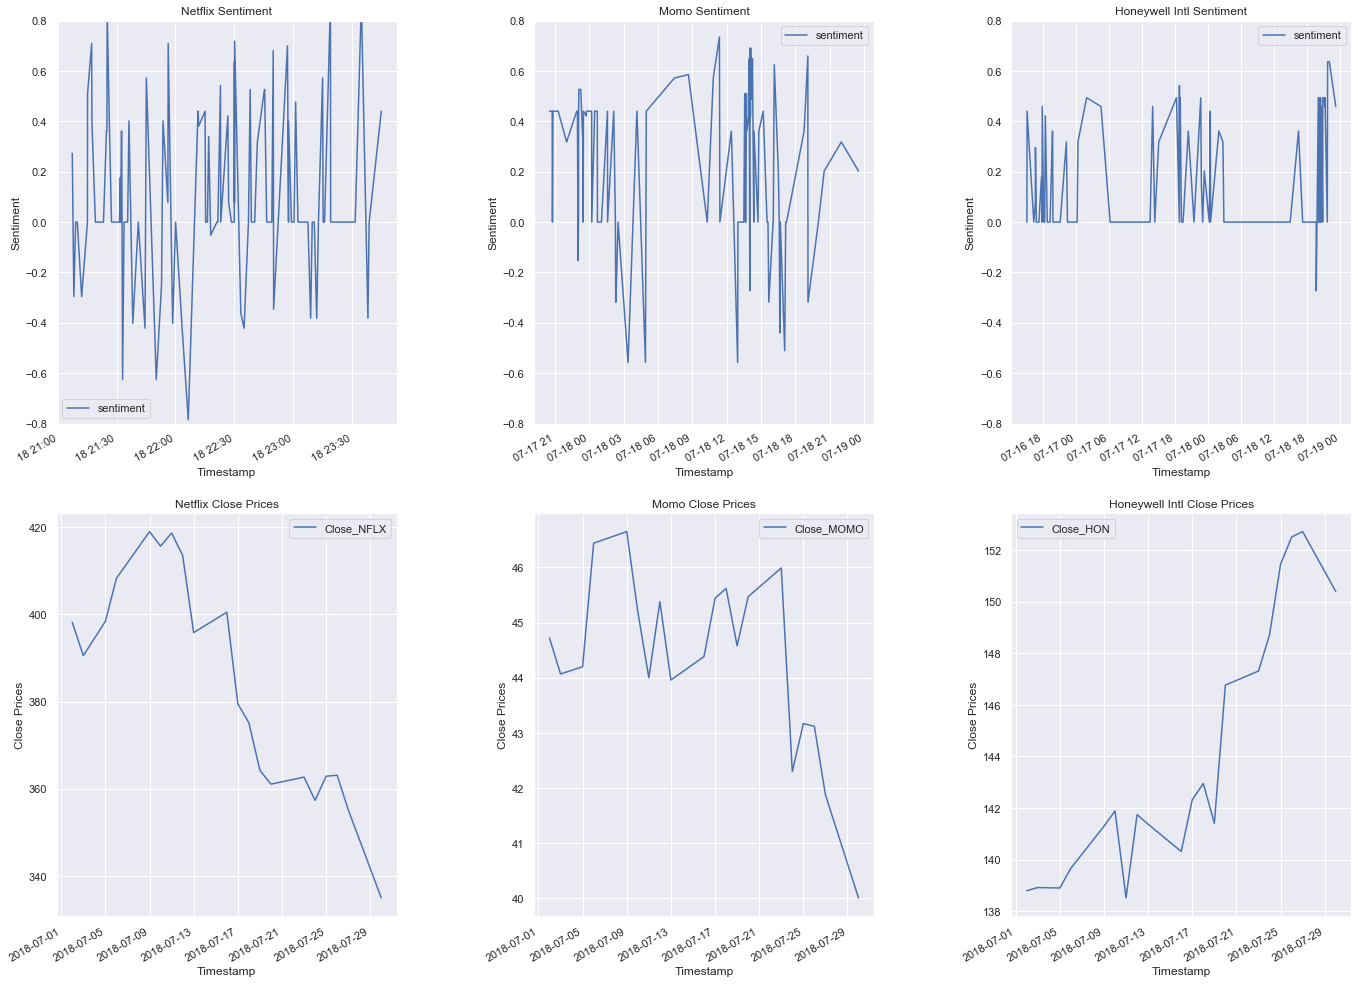

In [13]:
fig, axs = plt.subplots(2, 3)
syms = relevant_tickers.symbols
fig.tight_layout(pad=0.25)

# Graph Sentiment vs Time for 3 companies
axs[0, 0].set_ylim([-0.8, 0.8]); axs[0, 1].set_ylim([-0.8, 0.8]); axs[0, 2].set_ylim([-0.8, 0.8])
sentiment_kwargs = {'x': 'timestamp', 'y': 'sentiment', 'figsize': (20, 16), 'ylabel': 'Sentiment', 'xlabel': 'Timestamp'}

relevant_tickers[syms == 'NFLX'].plot.line(ax=axs[0, 0], title='Netflix Sentiment', **sentiment_kwargs)
relevant_tickers[syms == 'MOMO'].plot.line(ax=axs[0, 1], title='Momo Sentiment', **sentiment_kwargs)
relevant_tickers[syms == 'HON'].plot.line(ax=axs[0, 2], title='Honeywell Intl Sentiment', **sentiment_kwargs)

# Graph stock performance vs Time for 3 companies
price_kwargs = {'xlabel': 'Timestamp', 'ylabel': 'Close Prices', 'use_index': True}

stocks_df.plot.line(y='Close_NFLX', ax=axs[1, 0], title='Netflix Close Prices', **price_kwargs)
stocks_df.plot.line(y='Close_MOMO', ax=axs[1, 1], title='Momo Close Prices', **price_kwargs)
stocks_df.plot.line(y='Close_HON', ax=axs[1, 2], title='Honeywell Intl Close Prices', **price_kwargs)

We wanted to note that we used close prices to allow for the possibility that tweets/events on that day might influence the stock price. This would have a minor effect on stock price if any.

Unfortunately, it does not look like there is any real correlation between the sentiment and stock prices here. I hypothesize that the problem is just with our current Twitter dataset since these tweets do not contain significant sentiment, yet we are still tagging it with a sentiment value. Now let's move on to doing similar analysis but with tweets pulled in from the Twitter API to see if this remedies the issue.

# Twitter API
The Kaggle Twitter dataset was interesting and provided a starting place for analysis. Since this data was already labeled with information such as the source and stocks that it mentioned, it was easy to compare against information pulled from the Yahoo Finance API. To try and find some more insight into indicators of stock performance we will use the Twitter API to get tweets that directly mention the companies we are looking at. Hopefully, this will produce more opinionated data which will make better use of our sentiment analysis

In [14]:
# Connect to the Twitter API using our dev account credentials
auth = tweepy.AppAuthHandler(config.api_key, config.api_secret)
api = tweepy.API(auth)

In [15]:
# This will be the datastructure we build our dataframe from later
search_res = [["Company", "Symbol", "Date", "Tweet"]]

# Get today's date and all the companies we will want to search for on Twitter
date = datetime.today()
company_handle = ["Apple", "exxonmobil", "Walmart", "cvspharmacy", "CapitalOne"]
companies = ["Apple", "Exxon", "Walmart", "CVS", "Capital One"]
tickers = ["AAPL", "XOM", "WMT", "CVS", "COF"]

In [16]:
for i in range(len(companies)):
    days_ago = 6
    
    while days_ago >= 0:
        # Construct our Twitter query for this exact day and company
        query = "to:" + company_handle[i] + " since:" + (date - timedelta(days=days_ago)).strftime('%Y-%m-%d') + " until:" + (date - timedelta(days=days_ago-1)).strftime('%Y-%m-%d')
        tweets = api.search(q=query, lang="en", count=50)
        
        for twt in tweets:
            # Add to our dataframe proxy
            search_res.append([companies[i], tickers[i], (date - timedelta(days=days_ago)).strftime('%Y-%m-%d'), twt.text])
        
        days_ago -= 1
        
search_res[:5]

[['Company', 'Symbol', 'Date', 'Tweet'],
 ['Apple',
  'AAPL',
  '2020-12-10',
  '@Apple is worth more than the entire Canadian economy, yet they still cant figure out a way to make my battery last more than 5 seconds.'],
 ['Apple',
  'AAPL',
  '2020-12-10',
  '@Apple Anyone having issues with their i messages not showing d'],
 ['Apple', 'AAPL', '2020-12-10', '@Apple @RodolfoDvm9 look at this honey😱'],
 ['Apple',
  'AAPL',
  '2020-12-10',
  '@apple make your :japanese_ogre: emoji better why he so hapy https://t.co/KLu0jj806e']]

In [17]:
# Construct the new Tweet dataframe
tweet_df = pd.DataFrame(search_res)
tweet_df.columns = tweet_df.iloc[0]
tweet_df = tweet_df.iloc[1:]

# Clean up the Tweets with NLP and add the Vader sentiment score
tweet_df["Tweet"] = tweet_df["Tweet"].apply(clean_tweet)
tweet_df["Sentiment"] = tweet_df["Tweet"].apply(lambda s: sent.polarity_scores(s)['compound'])
tweet_df.head()

,Company,Symbol,Date,Tweet,Sentiment
1,Apple,AAPL,2020-12-10,worth entire canadian economy yet still cant f...,0.2263
2,Apple,AAPL,2020-12-10,anyone issues messages showing,0.0000
3,Apple,AAPL,2020-12-10,look honey,0.0000
4,Apple,AAPL,2020-12-10,make emoji better hapy,0.4404
5,Apple,AAPL,2020-12-10,let find reading messages without permission,0.0000


At this point we have queried the Twitter API for tweets about relevant companies from the last week. We used our previous NLP code to strip the tweets of all the unimportant information, and then we tagged each tweet with a Vader sentiment score.

Now we will pull in stock price information using YFinance to line up with the date of these tweets.

In [18]:
# Download stock price info for these companies for the past week
stocks_df = yf.download(tickers=tickers, start=((tweet_df.iloc[0])["Date"]), end=(date + timedelta(days=1)).strftime('%Y-%m-%d'))

# Only want Open, Close, and Volume. Drop the rest
stocks_df.drop(['Adj Close', 'Low', 'High', 'Open', 'Volume'], axis=1, inplace=True)

# Columns are multi-indexed, so flatten this
stocks_df.columns = ['_'.join(multi_col) for multi_col in stocks_df.columns]
stocks_df["Date"] = stocks_df.index
stocks_df.index = list(range(len(stocks_df.index)))
stocks_df.head()

[*********************100%***********************]  5 of 5 completed


,Close_AAPL,Close_COF,Close_CVS,Close_WMT,Close_XOM,Date
0,123.239998,94.669998,72.209999,147.039993,44.009998,2020-12-10
1,122.410004,92.169998,71.580002,147.000000,43.799999,2020-12-11
2,121.779999,90.419998,69.720001,145.649994,42.220001,2020-12-14
3,127.879997,92.680000,69.889999,145.580002,43.040001,2020-12-15
4,127.809998,93.589996,69.320000,145.429993,43.700001,2020-12-16


Now we want to actually tidy our stocks dataset since we also want to line it up with our tweets. We will use pd.melt to do so. Then we can merge this dataframe with our Tweets dataframe to look at close prices corresponding to the date of tweets about that company.

In [19]:
# Tidy the stocks dataframe
stocks_df = pd.melt(stocks_df, id_vars=["Date"], value_vars=["Close_AAPL", "Close_COF", "Close_CVS", "Close_WMT", "Close_XOM"])
stocks_df.columns = ["Date", "Symbol", "Close"]

# Remove the "Close_" from what used to be column names
stocks_df["Symbol"] = stocks_df["Symbol"].str[6:]

# Write out the date as a string so we can merge on it
stocks_df["Date"] = stocks_df["Date"].dt.strftime('%Y-%m-%d')

# Merge the Tweet dataframe with the stocks dataframe
tweet_df = tweet_df.merge(stocks_df, how="left", on=["Date", "Symbol"])
tweet_df.head()

,Company,Symbol,Date,Tweet,Sentiment,Close
0,Apple,AAPL,2020-12-10,worth entire canadian economy yet still cant f...,0.2263,123.239998
1,Apple,AAPL,2020-12-10,anyone issues messages showing,0.0000,123.239998
2,Apple,AAPL,2020-12-10,look honey,0.0000,123.239998
3,Apple,AAPL,2020-12-10,make emoji better hapy,0.4404,123.239998
4,Apple,AAPL,2020-12-10,let find reading messages without permission,0.0000,123.239998


We chose the five companies Apple, Capital One, CVS, Walmart, and Exxon Mobile so that we would have companies from several different industries rather than just technology or just finance. These companies were also chosen since they are well-known meaning that people would be more likely to tweet about them.

This dataframe now has a lot of interesting information. Each record in the table tells us about how people felt about a company on a certain date along with a numeric sentiment score and a stock price on that day.

Something interesting that we saw was that many tweets contained curse words and these tweets had a very low sentiment score which makes sense and gives us assurance that our sentiment tagging is working. We chose not to show these tweets since they contain explicatives.

Let's visualize this data!
- We will first show a violin plot of sentiment for several companies
- Then we will show sentiment vs stock prices for several companies

Text(0, 0.5, 'Sentiment')

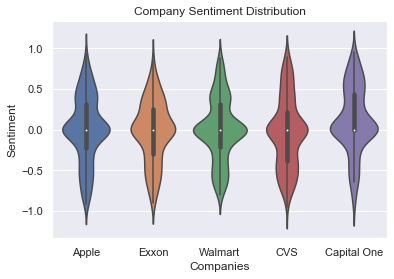

In [22]:
# Violin plot to show sentiment distribution
ax = sns.violinplot(x='Company', y='Sentiment', data=tweet_df)
ax.set_title('Company Sentiment Distribution')
ax.set_xlabel('Companies')
ax.set_ylabel('Sentiment')

These distributions tell us that the sentiment for most tweets is still neutral, but there is a better distribution of sentiment on these tweets compared to our last dataset which is a nice indicator. Let's see how the sentiment of these tweets fares against our close price data.

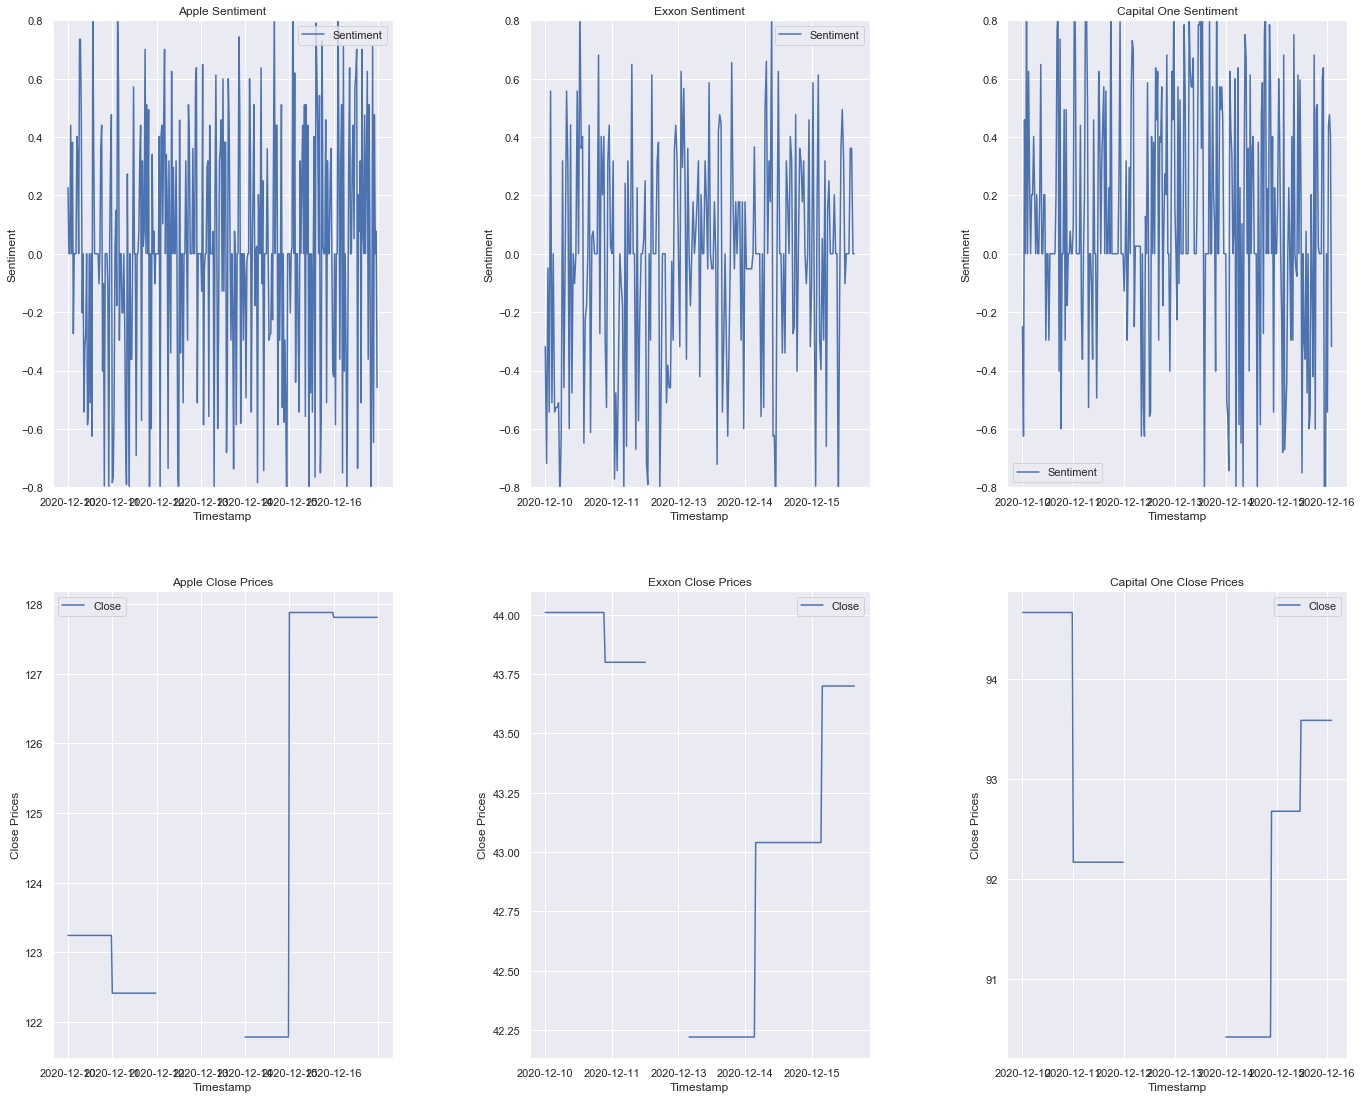

In [20]:
fig, axs = plt.subplots(2, 3)
syms = tweet_df.Symbol
fig.tight_layout(pad=0.25)

# Graph Sentiment vs Time for 3 companies
axs[0, 0].set_ylim([-0.8, 0.8]); axs[0, 1].set_ylim([-0.8, 0.8]); axs[0, 2].set_ylim([-0.8, 0.8])
sentiment_kwargs = {'x': 'Date', 'y': 'Sentiment', 'figsize': (20, 16), 'ylabel': 'Sentiment', 'xlabel': 'Timestamp'}

tweet_df[syms == 'AAPL'].plot.line(ax=axs[0, 0], title='Apple Sentiment', **sentiment_kwargs)
tweet_df[syms == 'XOM'].plot.line(ax=axs[0, 1], title='Exxon Sentiment', **sentiment_kwargs)
tweet_df[syms == 'COF'].plot.line(ax=axs[0, 2], title='Capital One Sentiment', **sentiment_kwargs)

# Graph stock performance vs Time for 3 companies
price_kwargs = {'x': 'Date', 'y': 'Close', 'xlabel': 'Timestamp', 'ylabel': 'Close Prices'}

tweet_df[syms == 'AAPL'].plot.line(ax=axs[1, 0], title='Apple Close Prices', **price_kwargs)
tweet_df[syms == 'XOM'].plot.line(ax=axs[1, 1], title='Exxon Close Prices', **price_kwargs)
tweet_df[syms == 'COF'].plot.line(ax=axs[1, 2], title='Capital One Close Prices', **price_kwargs)

These sentiment graphs are definitely more extreme than before which is an improvement on our previous Twitter dataset since we have actual sentiment we can track. The issue is that we can only look at 7 days of Tweets with our developer account which is not enough to really see people's feelings about a company over time.

The stock price data also has gaps in it because we are looking at a week's worth of data and the market is not open on weekends.

The Twitter API definitely performed better than the Kaggle Twitter dataset since these tweets are much more emotional in nature which makes the Vader sentiment tagging more valuable. We are limited by the fact that we can only look at 7 days of tweets which means this API hits a bit of a dead end.

# Reddit API
Twitter has been commonly used by large companies to report to the general public on news. We will now look at the Reddit API to see if we can generate more interesting correlations to provide insight into stock performance.